In [3]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import plot_utils
import json
from dataclasses import dataclass, field
from typing import Dict, List, Optional, Iterator
import os

@dataclass
class RequestFuncOutput:
    rid: str = ""
    num_gpus: int = 0
    prompt_text: str = ""
    generated_text: str = ""
    success: bool = False
    request_latency: float = 0
    normalized_latency: float = 0
    ttft: float = 0  # Time to first token
    itl: List[float] = field(default_factory=list)  # List of inter-token latencies
    prompt_len: int = 0
    error: str = ""
    global_time: float = 0
    output_len: float = None
    tpot: float = None
    prefill_decode_ratio: float = None
    send_out_time: float = 0.0
    arrival_time: float = 0.0
    append_to_queue_time: float = 0.0
    route_dest: int = None
    scheduling_overhead: float = 0.0
    runtime_selected :int = 0
    max_new_tokens: int = 0

In [4]:
# !pip3 install pandas matplotlib numpy

In [5]:
def retrive_request_outputs(path):
    with open(path, 'r') as file:
        data = json.load(file)
        outputs = [RequestFuncOutput(**d) for d in data]
    return outputs

def get_avg_norm_latency(outputs: List[RequestFuncOutput]) -> float:
    norm_latency = [o.request_latency / o.output_len for o in outputs if o.request_latency if o.output_len]
    return np.mean(norm_latency)

In [6]:
paths = []
for subdir, dirs, files in os.walk('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_toolbench'):
    for file in files:
        if file.endswith('.json'):
            paths.append((file, os.path.join(subdir, file)))
for file, path in sorted(paths):
    print(file, get_avg_norm_latency(retrive_request_outputs(path)))

# Mistral E2E

In [7]:
def plot_all_metrics(fpath, ax, y_columns, x_lim=None):
    df = plot_utils.read_e2e_csv_metrics(fpath)
    for i, y_column in enumerate(y_columns):
        for name, group in df:
            if "ORACLE" in name[1]:
                name = ('CUSTOM', 'ORACLE')
            ax[i].plot(group['rps'], group[y_column], **plot_utils.policy_mapping[':'.join(name)])
            ax[i].set_xlabel('RPS')
            ax[i].legend()
            ax[i].set_title(y_column)
            if x_lim:
                ax[i].set_xlim(x_lim)

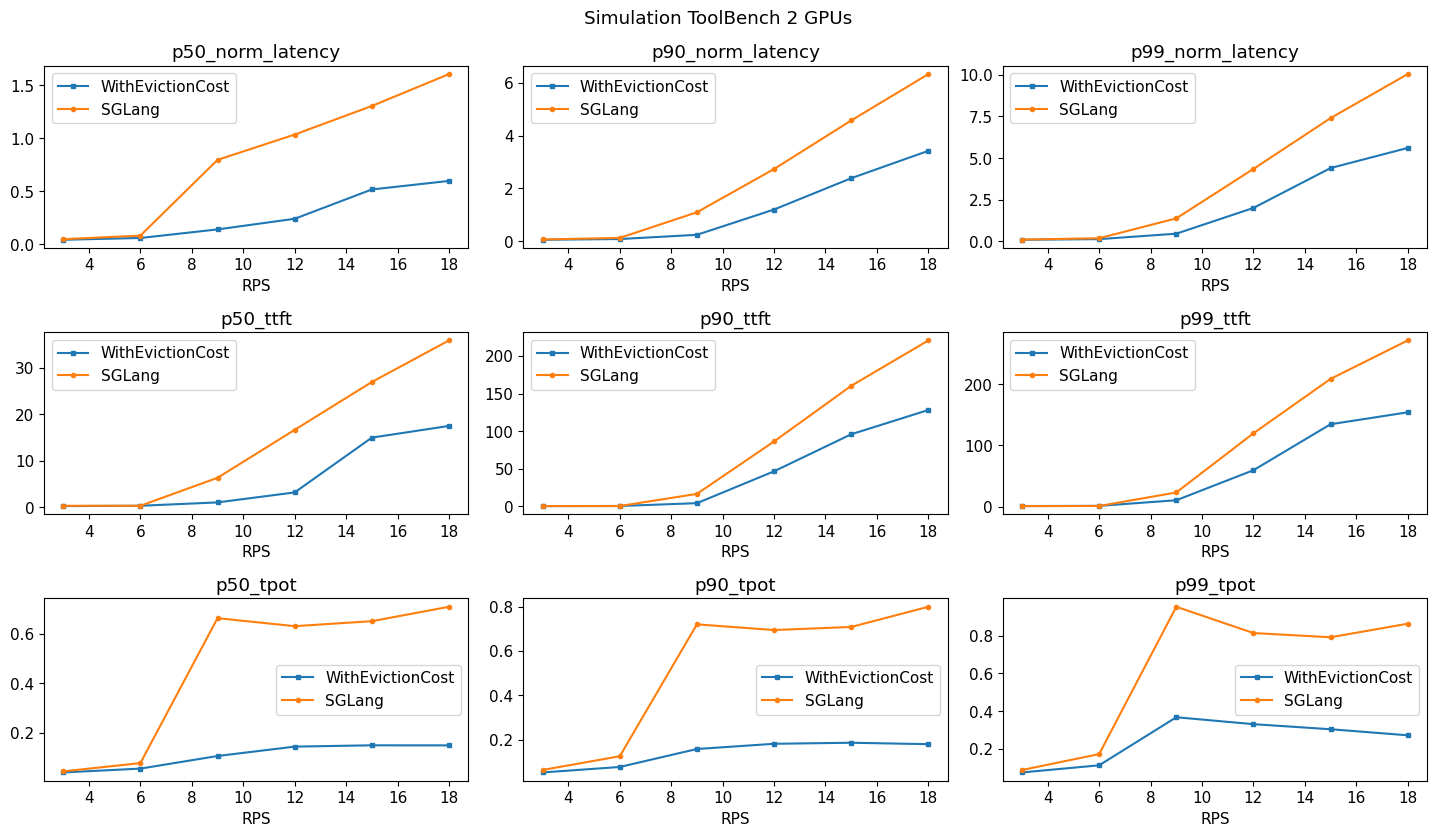

In [8]:
fig, ax = plt.subplots(3, 3, figsize=(14.5, 8.5))
y_columns = ['p50_norm_latency', 'p90_norm_latency', 'p99_norm_latency']
y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Simulation ToolBench 2 GPUs')
plt.tight_layout()

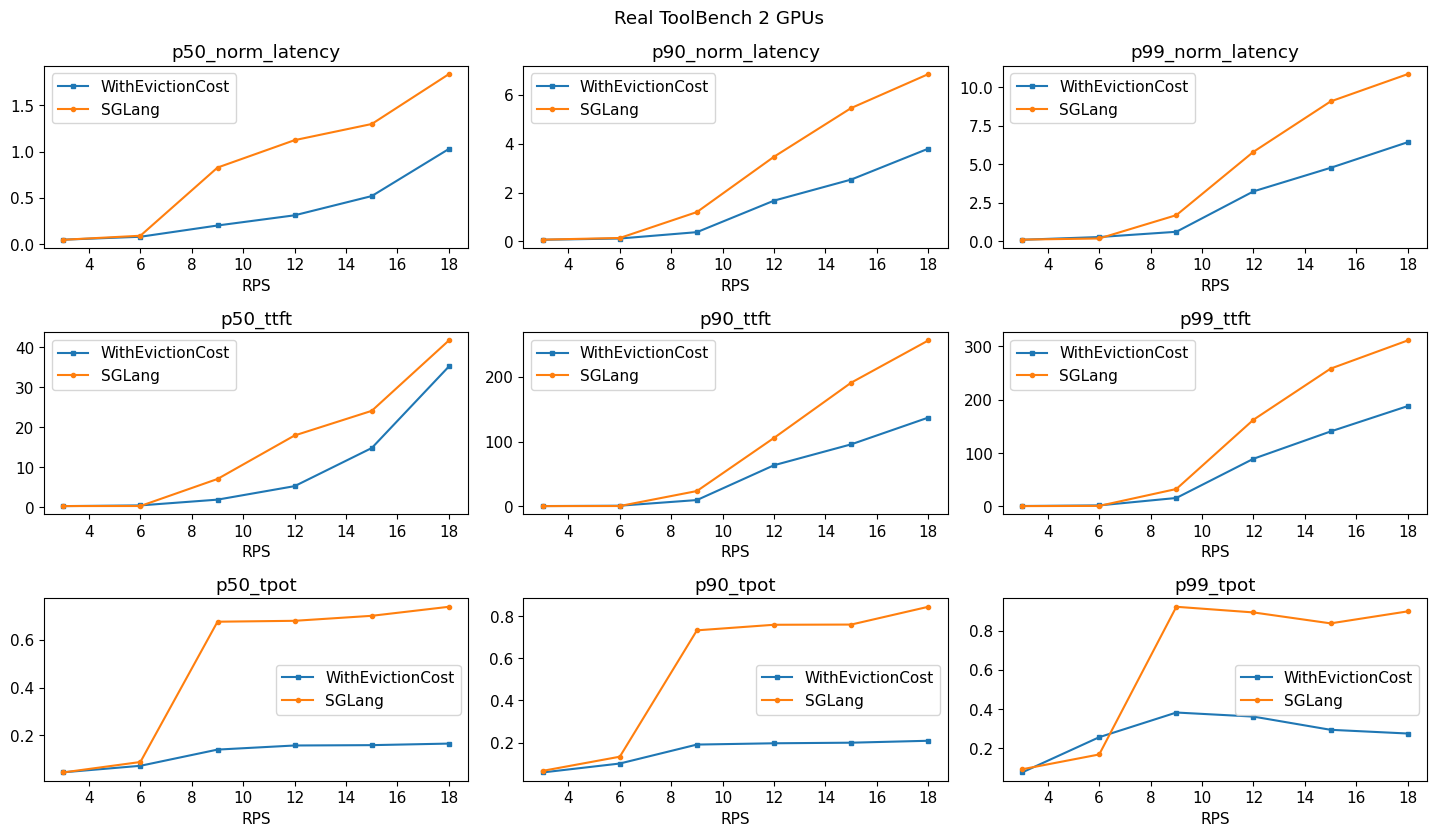

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(14.5, 8.5))
y_columns = ['p50_norm_latency', 'p90_norm_latency', 'p99_norm_latency']
y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_toolbench/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Real ToolBench 2 GPUs')
plt.tight_layout()

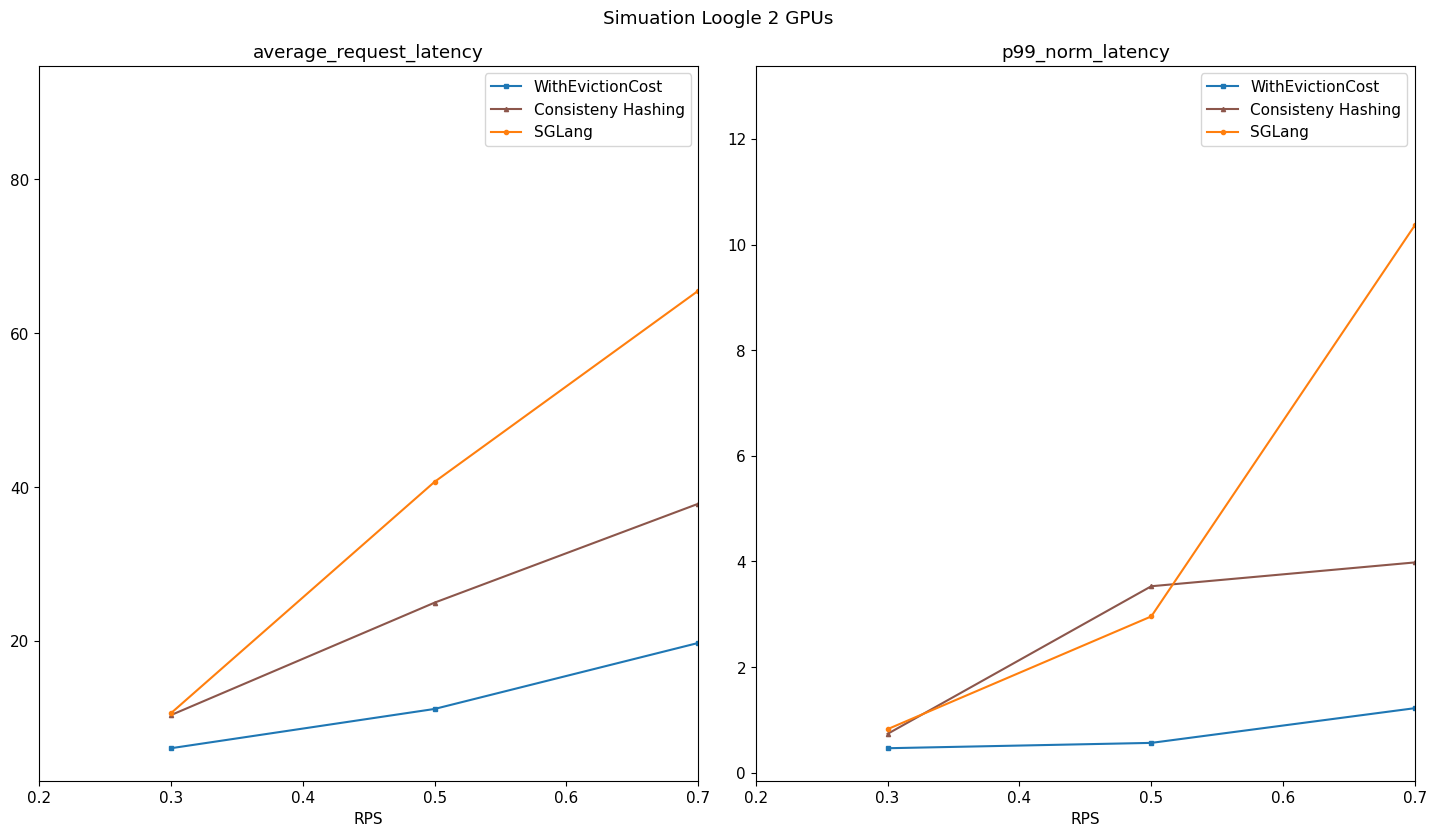

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(14.5, 8.5))
y_columns = ['average_request_latency', 'p99_norm_latency']
y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10/exp.csv', '/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10_rps>0.7/exp.csv'], ax, y_columns, x_lim=(0.2, 0.7))
# plot_all_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10/exp.csv', '/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10_rps>0.7/exp.csv'], ax[1], y_columns1, x_lim=(0.2, 0.7))
# plot_all_metrics(['/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10/exp.csv', '/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_loogle_k=10_rps>0.7/exp.csv'], ax[2], y_columns2, x_lim=(0.2, 0.7))
fig.suptitle('Simuation Loogle 2 GPUs')
plt.tight_layout()

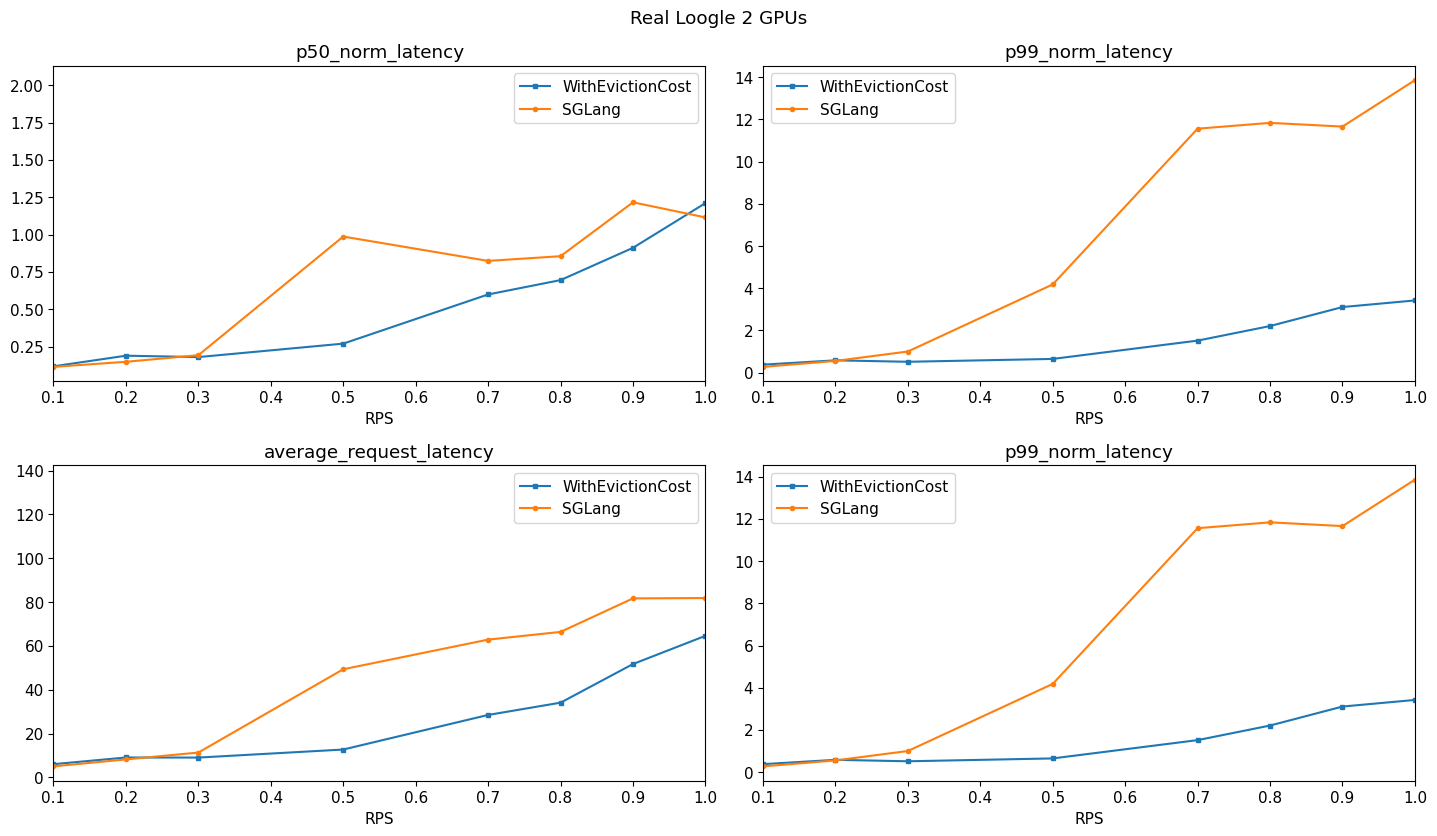

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['p50_norm_latency', 'p99_norm_latency']
y_columns1 = ['average_request_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_loogle/exp.csv', ax[0], y_columns, x_lim=(0.1, 1.0))
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_loogle/exp.csv', ax[1], y_columns1, x_lim=(0.1, 1.0))
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_loogle/exp.csv', ax[2], y_columns2)
fig.suptitle('Real Loogle 2 GPUs')
plt.tight_layout()

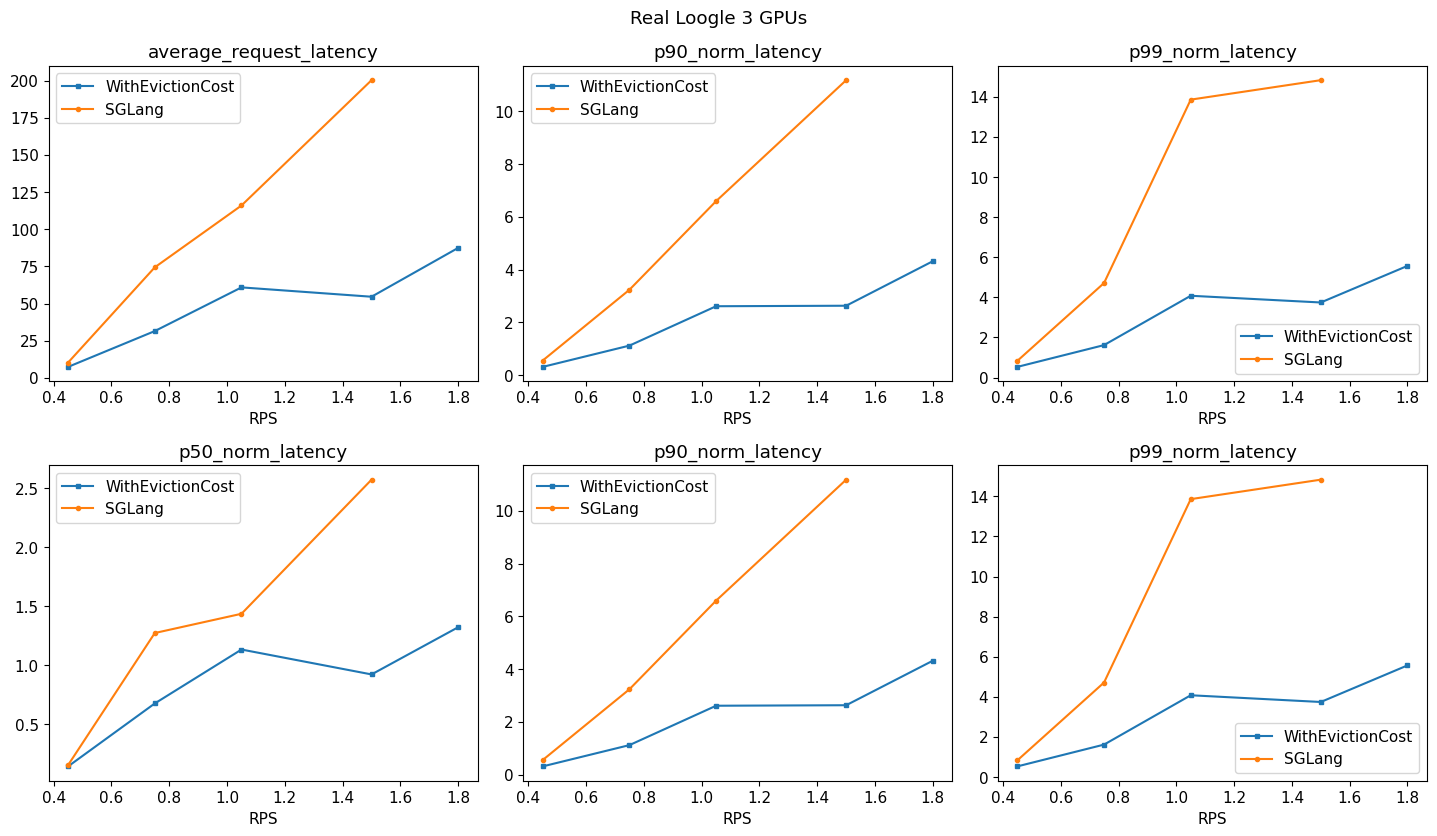

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(14.5, 8.5))
y_columns = ['p50_norm_latency', 'p90_norm_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
y_columns2 = ['average_request_latency', 'p90_norm_latency', 'p99_norm_latency']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/3r_loogle/exp.csv', ax[0], y_columns2)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/3r_loogle/exp.csv', ax[1], y_columns1)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/3r_loogle/exp.csv', ax[1], y_columns)
fig.suptitle('Real Loogle 3 GPUs')
plt.tight_layout()

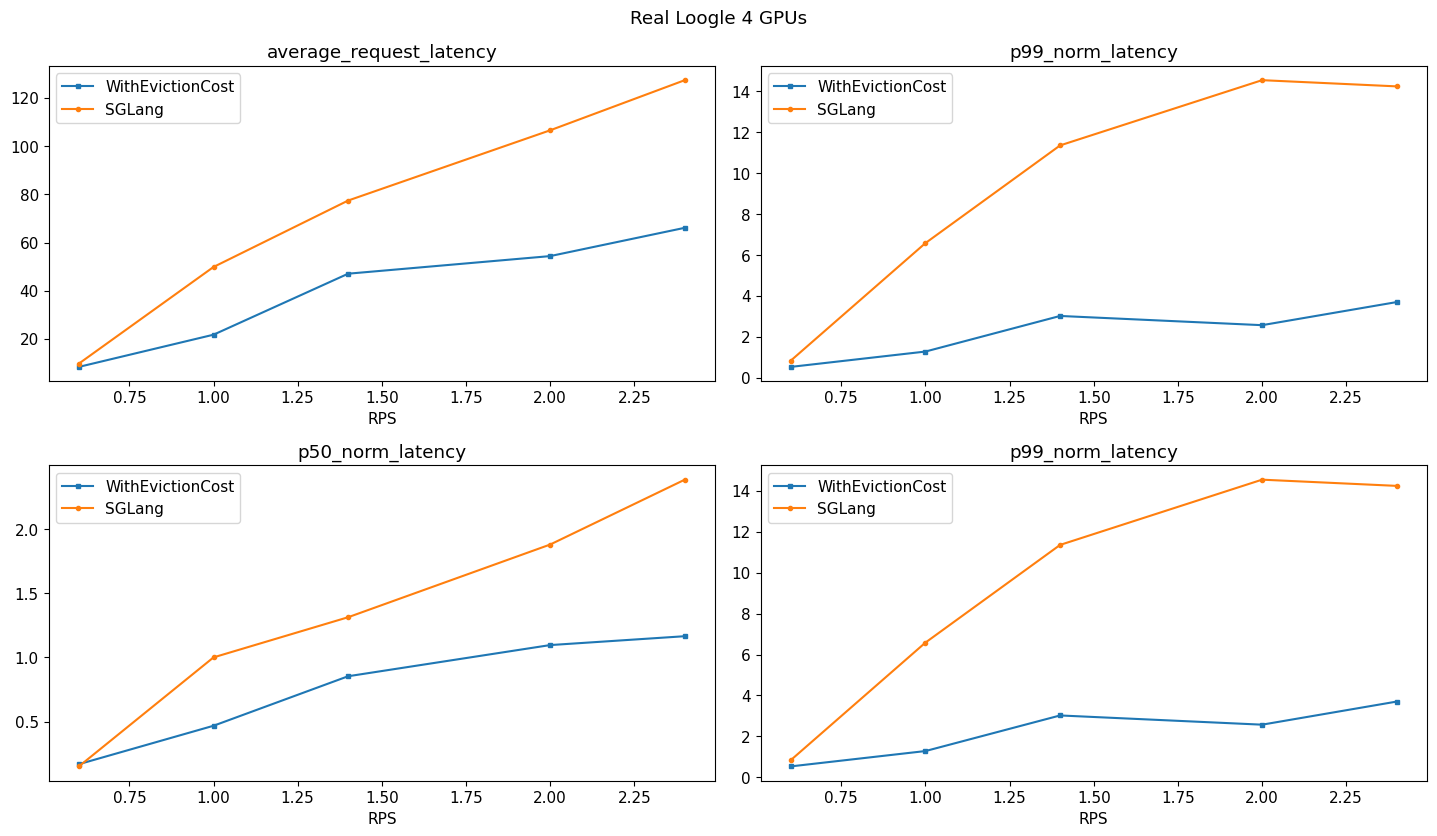

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['average_request_latency', 'p99_norm_latency']
y_columns1 = ['p50_norm_latency', 'p99_norm_latency']
# y_columns1 = ['average_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/4r_loogle/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/4r_loogle/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/multi_node/benchmarks/real_ckpt_all_in_one/4r_loogle/exp.csv', ax[2], y_columns2)
fig.suptitle('Real Loogle 4 GPUs')
plt.tight_layout()

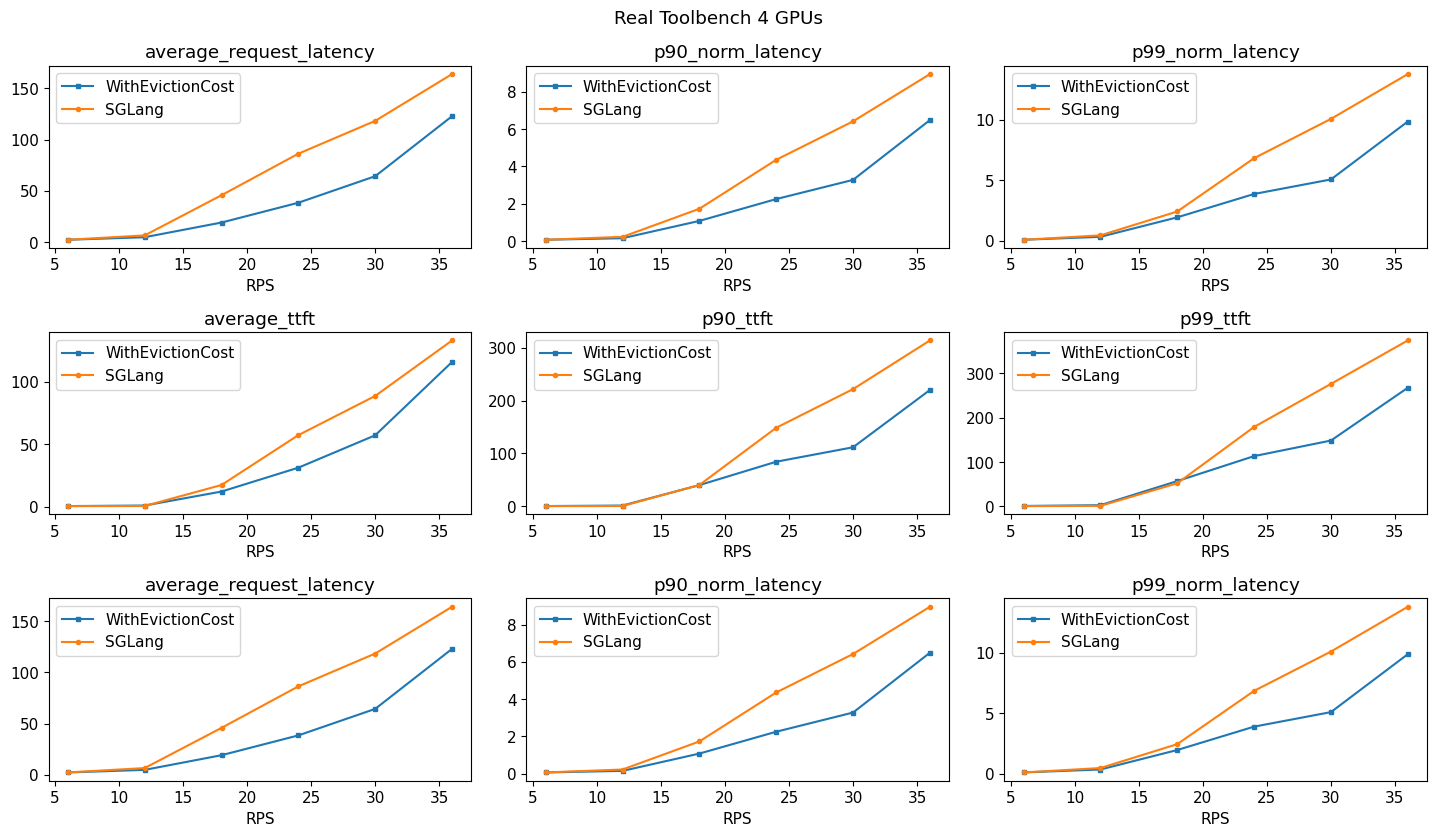

In [11]:
fig, ax = plt.subplots(3, 3, figsize=(14.5, 8.5))
y_columns = ['average_request_latency', 'p90_norm_latency', 'p99_norm_latency']
y_columns1 = ['average_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/4r_toolbench/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/4r_toolbench/exp.csv', ax[1], y_columns1)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/4r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Real Toolbench 4 GPUs')
plt.tight_layout()

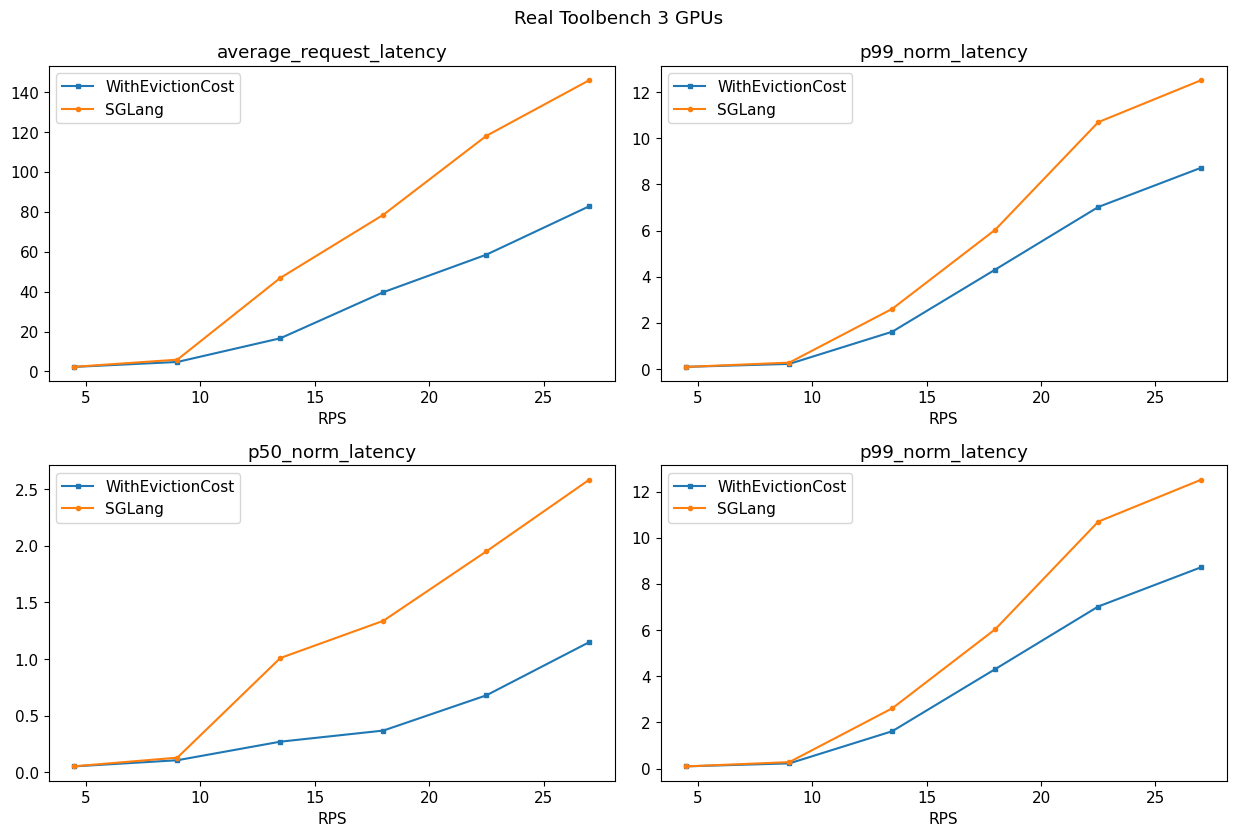

In [12]:
fig, ax = plt.subplots(2, 2, figsize=(12.5, 8.5))
y_columns = ['average_request_latency', 'p99_norm_latency']
y_columns1 = ['p50_norm_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax, y_columns2)
fig.suptitle('Real Toolbench 3 GPUs')
plt.tight_layout()

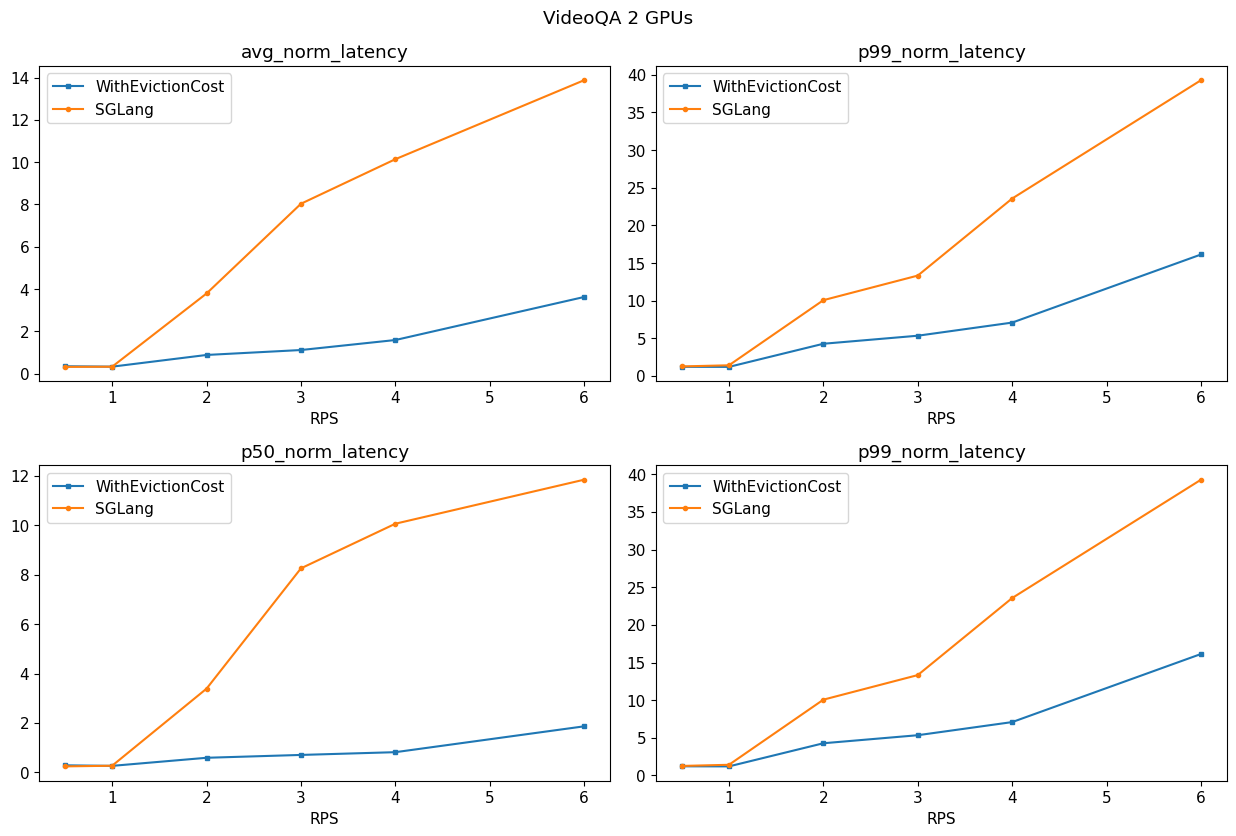

In [14]:
fig, ax = plt.subplots(2, 2, figsize=(12.5, 8.5))
y_columns = ['avg_norm_latency', 'p99_norm_latency']
y_columns1 = ['p50_norm_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_videoQA_s2/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/2r_videoQA_s2/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax, y_columns2)
fig.suptitle('VideoQA 2 GPUs')
plt.tight_layout()

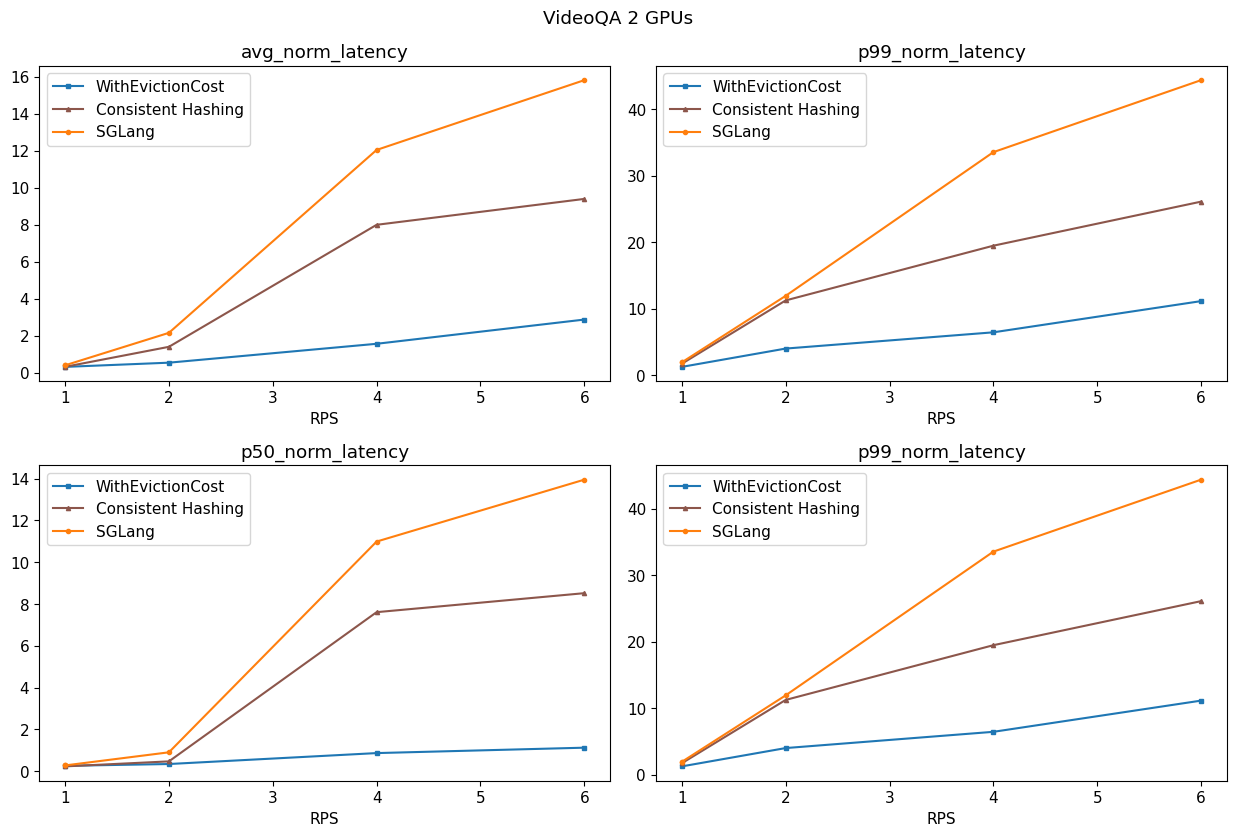

In [5]:
fig, ax = plt.subplots(2, 2, figsize=(12.5, 8.5))
y_columns = ['avg_norm_latency', 'p99_norm_latency']
y_columns1 = ['p50_norm_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_videoQA_proportional_to_video_length/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_videoQA_proportional_to_video_length/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax, y_columns2)
fig.suptitle('VideoQA 2 GPUs')
plt.tight_layout()

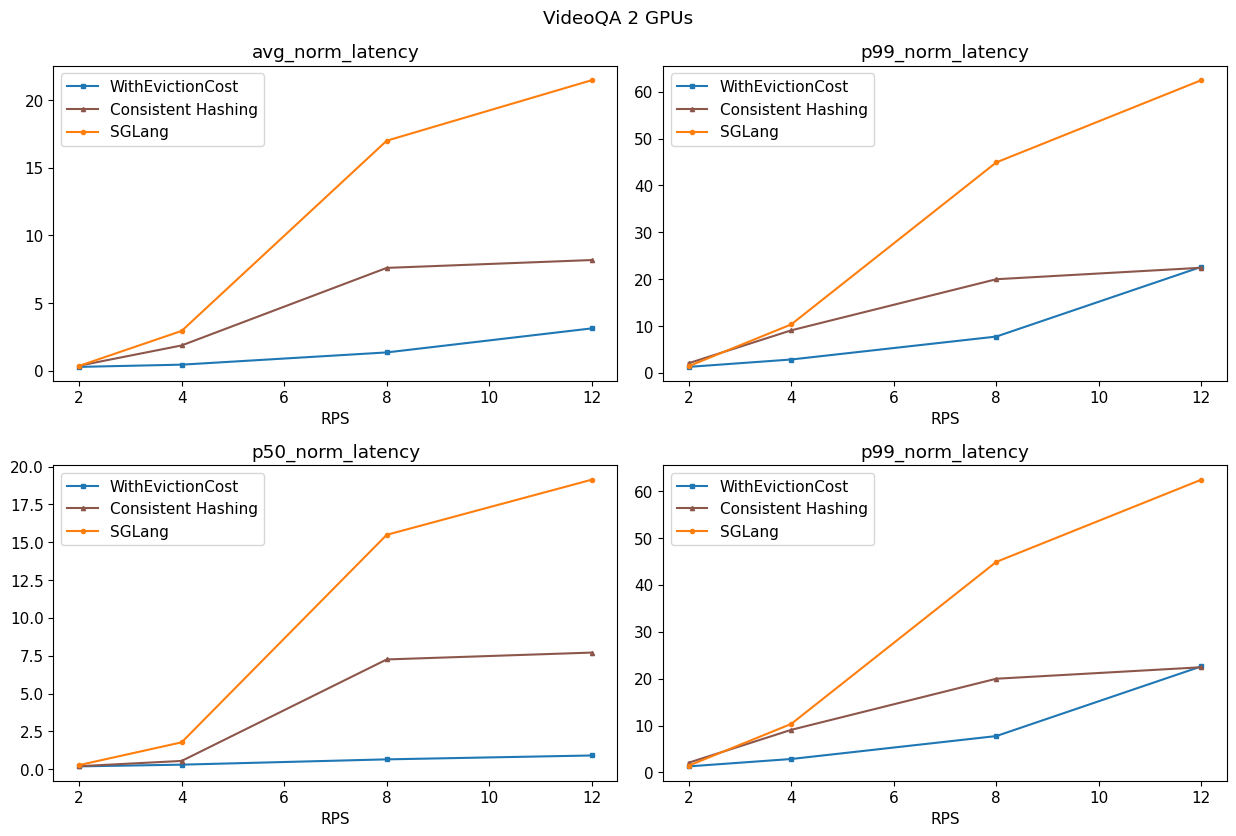

In [7]:
fig, ax = plt.subplots(2, 2, figsize=(12.5, 8.5))
y_columns = ['avg_norm_latency', 'p99_norm_latency']
y_columns1 = ['p50_norm_latency', 'p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/4r_videoQA_proportional_to_video_length/exp.csv', ax[0], y_columns)
plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/4r_videoQA_proportional_to_video_length/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/real_ckpt_all_in_one/3r_toolbench/exp.csv', ax, y_columns2)
fig.suptitle('VideoQA 4 GPUs')
plt.tight_layout()

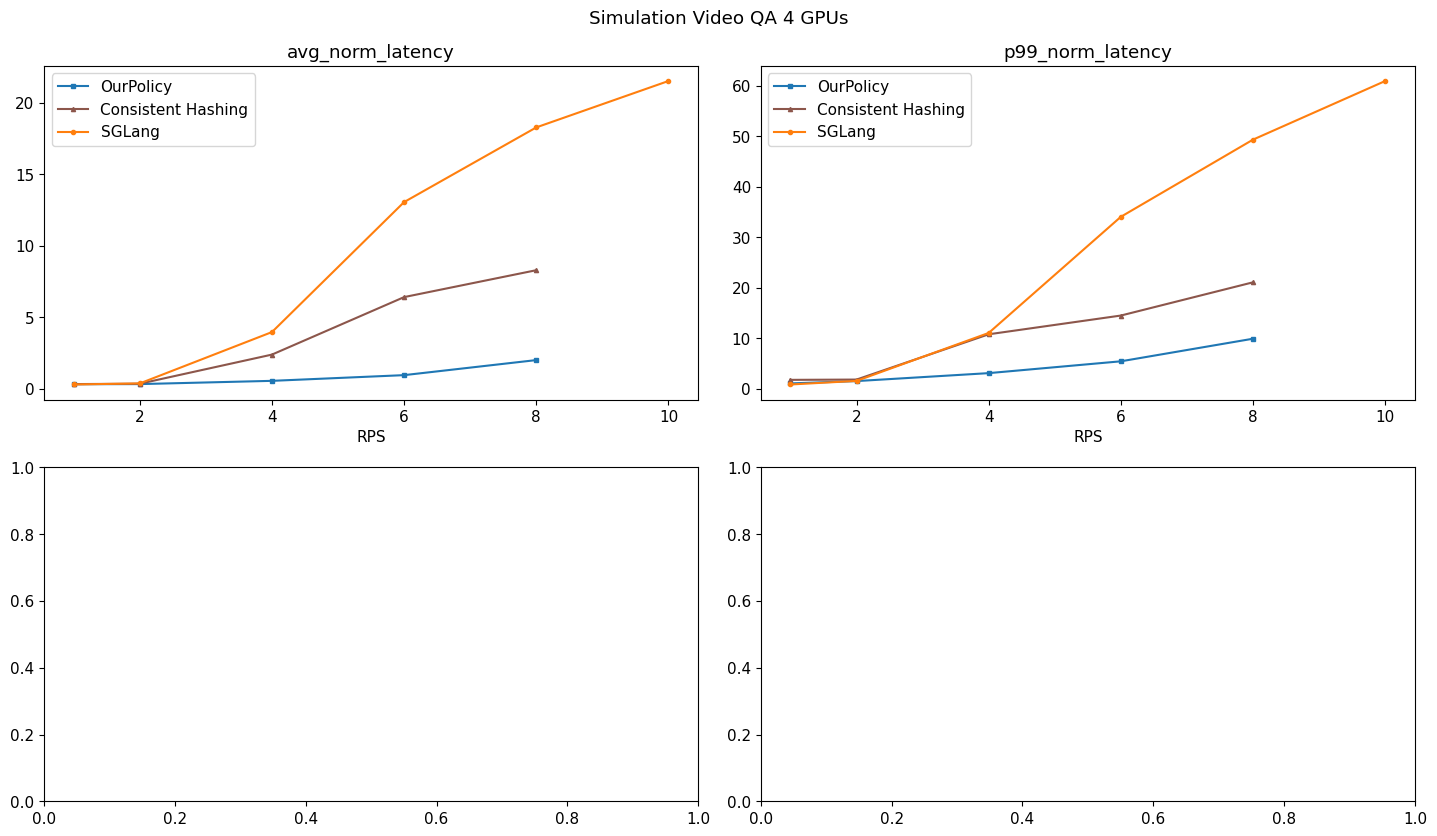

In [17]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['avg_norm_latency','p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/workspace/stateful_llm_serving/multi_node/benchmarks/real_ckpt_all_in_one/4r_videoQA_proportional_to_video_length/exp.csv', ax[0], y_columns)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Simulation Video QA 4 GPUs')
plt.tight_layout()

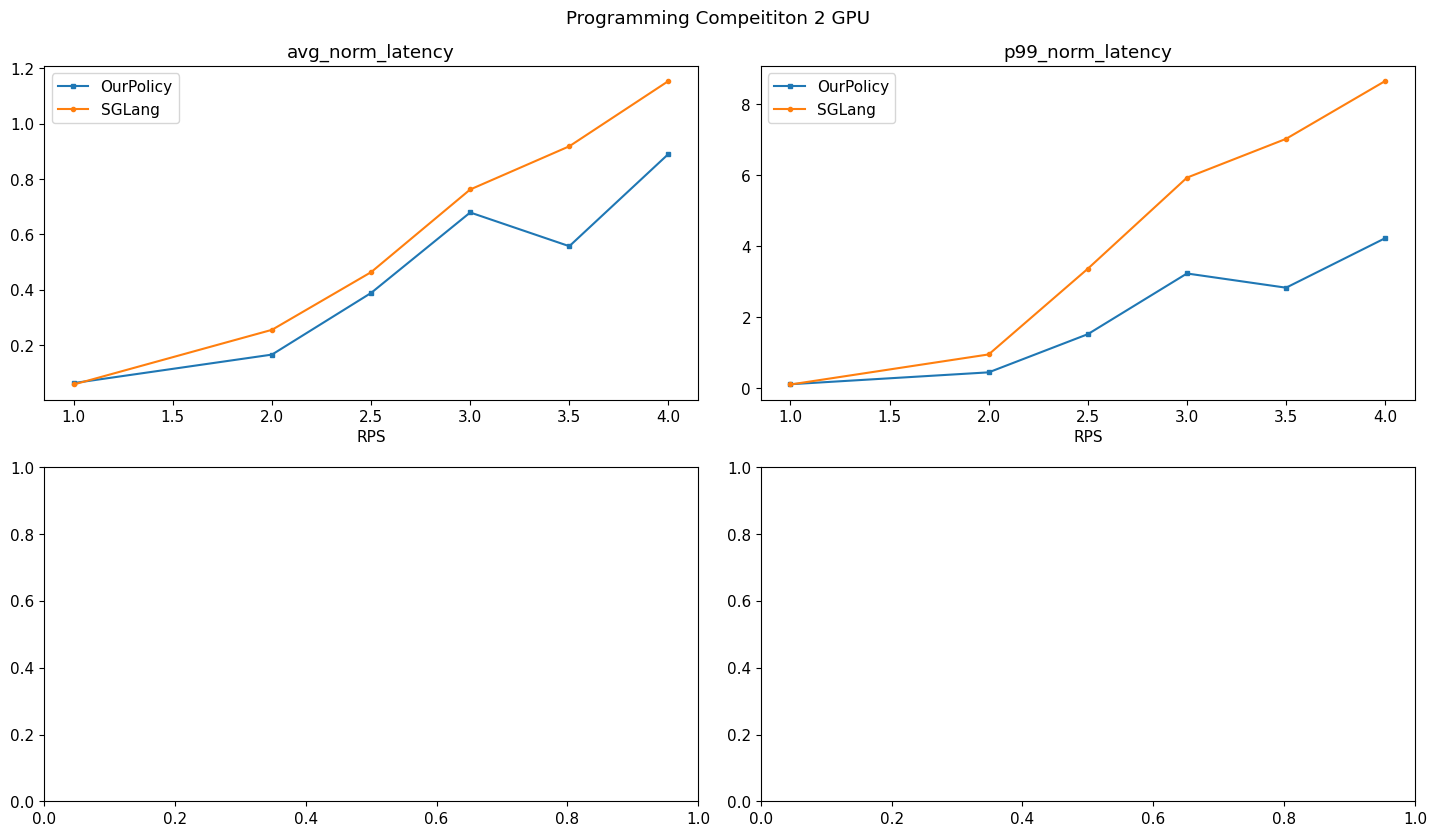

In [8]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['avg_norm_latency','p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/workspace/stateful_llm_serving/multi_node/benchmarks/real_ckpt_all_in_one/programming/2_gpu.csv', ax[0], y_columns)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Programming Compeititon 2 GPU')
plt.tight_layout()

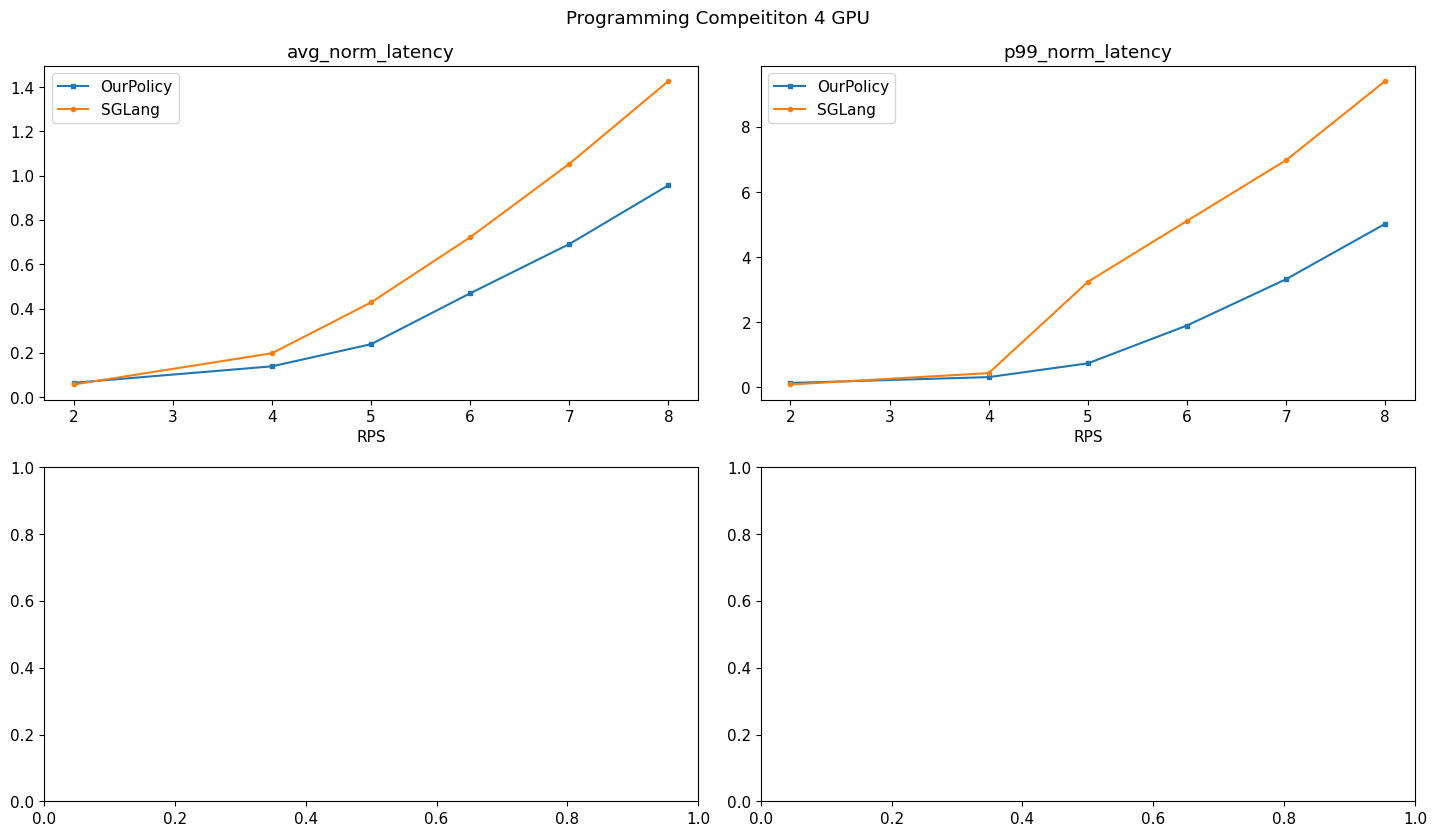

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['avg_norm_latency','p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/workspace/stateful_llm_serving/multi_node/benchmarks/real_ckpt_all_in_one/programming/4_gpu.csv', ax[0], y_columns)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Programming Compeititon 4 GPU')
plt.tight_layout()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['avg_norm_latency','p99_norm_latency']
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']
plot_all_metrics('/workspace/stateful_llm_serving/multi_node/benchmarks/real_ckpt_all_in_one/programming/4_gpu.csv', ax[0], y_columns)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)
fig.suptitle('Programming Compeititon 4 GPU')
plt.tight_layout()

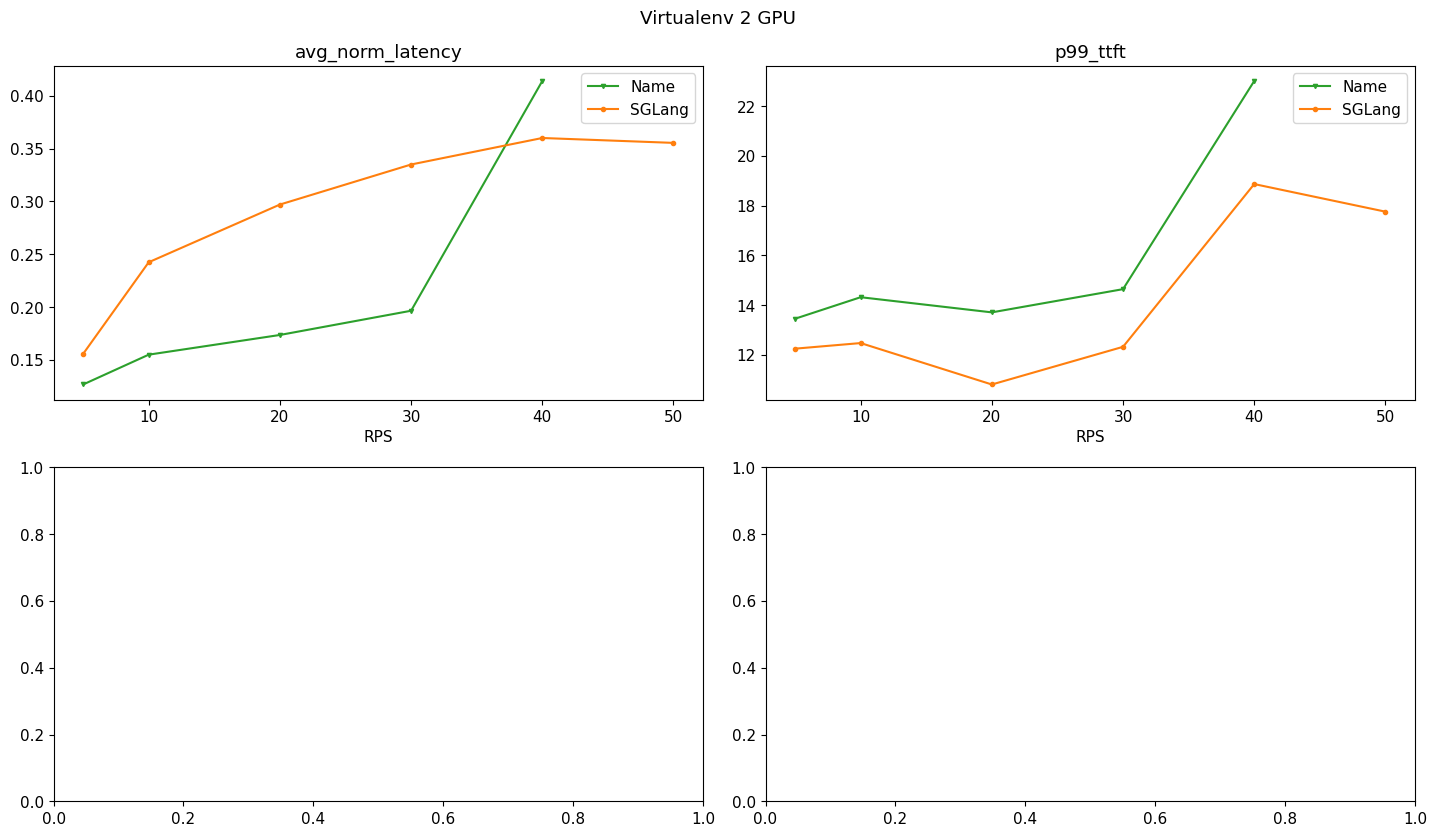

In [15]:
fig, ax = plt.subplots(2, 2, figsize=(14.5, 8.5))
y_columns = ['avg_norm_latency','p99_ttft', "p99_latency"]
# y_columns1 = ['p50_ttft', 'p90_ttft', 'p99_ttft']
# y_columns2 = ['p50_tpot', 'p90_tpot', 'p99_tpot']

plot_all_metrics('/workspace/stateful_llm_serving/multi_node/benchmarks/real_ckpt_all_in_one/virtualenv/e2e_virtualenv_5.csv', ax[0], y_columns)

# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[1], y_columns1)
# plot_all_metrics('/mnt/ssd1/alm-os/sglang_multi_model/ckpt_all_in_one/2r_toolbench/exp.csv', ax[2], y_columns2)

fig.suptitle('Virtualenv 2 GPU')
plt.tight_layout()
